# Computing a linear regression with Stan

In [1]:
import pandas
from plotnine import *
import warnings
import pystan
import numpy
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Dataset generation

First, we generate the dataset and plot it.

In [2]:
def generate_dataset(intercept, coefficient, N=1000, min_x=0, max_x=100, sigma=1):
    numpy.random.seed(42)
    x = numpy.random.randint(min_x, max_x, N)
    y = coefficient * x + intercept + numpy.random.normal(0, sigma, N)
    df = pandas.DataFrame({'x': x, 'y' : y})
    return df

df = generate_dataset(12, 3, 1000, sigma=10)
df.head()

,x,y
0,51,180.231241
1,92,293.389100
2,14,43.627538
3,71,223.096613
4,60,183.243817


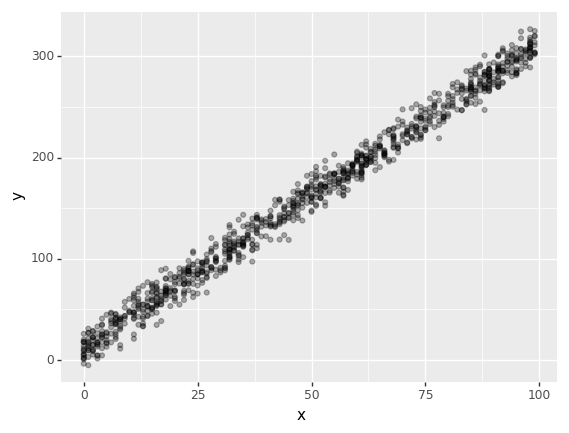

<ggplot: (8755435964708)>

In [3]:
ggplot(df, aes(x='x', y='y')) + geom_point(alpha=0.3)

## Stan modelling

Then, we define a Stan model and compute a fit.

In [4]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    vector[N] x;
    vector[N] y;
}
parameters {
    real intercept;
    real coefficient;
    real<lower=0> sigma;
}
model {
    // We define our priors
    intercept   ~ normal(0, 10);
    coefficient ~ normal(0, 10);
    sigma       ~ normal(0, 10);

    // Then, our likelihood function
    y ~ normal(coefficient*x + intercept, sigma);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3a8a28330dade2a4009f00f5de861246 NOW.


CPU times: user 862 ms, sys: 60 ms, total: 922 ms
Wall time: 58.1 s


Inference for Stan model: anon_model_3a8a28330dade2a4009f00f5de861246.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept    12.46    0.02   0.62  11.25  12.03  12.44  12.88  13.72   1125    1.0
coefficient    3.0  3.3e-4   0.01   2.98    3.0    3.0   3.01   3.02   1127    1.0
sigma         9.92  6.7e-3   0.22    9.5   9.78   9.92  10.07  10.37   1042    1.0
lp__         -2794    0.04   1.19  -2797  -2794  -2793  -2793  -2792    872    1.0

Samples were drawn using NUTS at Mon May  6 10:51:38 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 130 ms, sys: 33.4 ms, total: 163 ms
Wall time: 660 ms


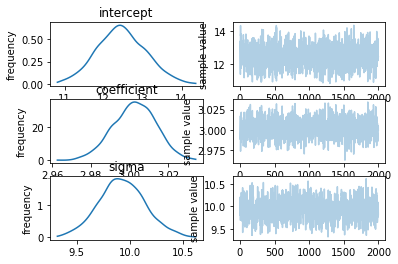

In [5]:
%%time

data = {
    'N': len(df),
    'x': df.x,
    'y': df.y
}

fit = sm.sampling(data=data, iter=500, chains=8)

print(fit)

fit.plot()